In [1]:
def getDist(cord1,cord2):
	return (
		(float(cord1[0])-float(cord2[0]))**2+
		(float(cord1[1])-float(cord2[1]))**2+
		(float(cord1[2])-float(cord2[2]))**2)**0.5 * 10

class gro:    # ndx = {chineID : (start atomNdx, end atomNdx)}
    def __init__(self, groFile):
        from tqdm import tqdm
        self.version = "groObj V.1"
        self.type = "Multi Chains"
        with open(groFile, "r") as gro:
            groLines = gro.readlines()
            self.atomNum = groLines[1]
        self.frames = {} # { frameNdx : { atomNdx : { resNdx : x, coord : (x, y, x) } } }
        frameNdx = 0
        atomDic = {}
        resNdx = groLines[2].split()[:-3]
        for line in tqdm(groLines[2:]):
            line_list = line.split()
            if len(line_list) == 3:
                self.frames[frameNdx] = atomDic
                frameNdx = frameNdx + 1
                atomDic = {}
            elif "Title" not in line and len(line.split()) > 3:
                #print(line)
                atomNdx = int(line.split()[2])
                atomDic[atomNdx] = {
                    "resNdx" : int(line.split()[0][:-3]),
                    "coord" : (
                        float(line.split()[3]),
                        float(line.split()[4]),
                        float(line.split()[5])
                    )
                }
    def getRes(self, ndx):
      frameDic = {} # { frameNdx : { resNdx : { atomNdx : (coord) } } }
      for frame in self.frames.items():# { frameNdx : { atomNdx : { resNdx : x, coord : (x, y, x) } } }
          frameNdx = frame[0]
          atomDic = frame[1]
          resDic = {}
          for atomNdx in range(ndx[0], ndx[1]+1):
              resNdx = atomDic[atomNdx]["resNdx"]
              coord = atomDic[atomNdx]["coord"]
              if resNdx not in list(resDic.keys()):
                  resDic[resNdx] = [coord]
              else:
                  resDic[resNdx].append(coord)
          frameDic[frameNdx] = resDic
      return frameDic

def contactPerFrame(frameNdx, proAtomNdx, ligAtomNdx, groObj):
    with open(groObj, "rb") as groDataFile:
        groData = pickle.load(groDataFile)
    ligRes = groData.getRes(ligAtomNdx)[frameNdx]
    proRes = groData.getRes(proAtomNdx)[frameNdx]
    #print(proRes[15])
    distDic = {}
    ligCoords = []
    for coord in ligRes.items():
        ligCoords = ligCoords + coord[1]
    
    for resID in proRes.keys():
        tmpDislist = []
        for resCoords in proRes[resID]:
            for ligCoord in ligCoords:
                #print(resAtom)
                tmpDislist.append(
                    getDist(resCoords, ligCoord)
                )
        distDic[resID] = round(min(tmpDislist), 3)
    #print(distDic)
    distDic["frameNdx"] = frameNdx
    dataFrame = pd.DataFrame([distDic])
    return dataFrame


In [2]:
groData = gro("fit.gro")
import pickle
with open("groData.pkl", "wb") as groDataFile:
    pickle.dump(groData, groDataFile)

100%|██████████| 3258253/3258253 [00:39<00:00, 81739.77it/s] 


In [4]:
import pandas as pd
import pickle

frameNdx = 0
proAtomNdx = (1, 2863)
ligAtomNdx = (2864, 3252)
contactPerFrame(frameNdx, proAtomNdx, ligAtomNdx, "groData.pkl")


,15,16,17,18,19,20,21,22,23,24,...,185,186,187,188,189,190,191,192,193,frameNdx
0,9.999,12.464,9.526,4.496,1.94,7.343,8.235,2.069,6.723,2.375,...,13.173,5.169,13.098,11.494,13.857,17.426,13.483,10.578,14.22,0


In [2]:
import pickle
import pandas as pd
from tqdm import tqdm
#print("> loading data")
#with open("groData.pkl", "rb") as groDataFile:
#    groData = pickle.load(groDataFile)
#print("> loaded data")
#for item in groData.frames[1000][15].items():
#    print(item)
from joblib import Parallel, delayed
print("> joblib imported")
proAtomNdx = (1, 2863)
ligAtomNdx = (2864, 3252)
print("> startting multiProcessing")
results = Parallel(
    n_jobs=64, backend='multiprocessing'
    )(delayed(contactPerFrame)(frameNdx, proAtomNdx, ligAtomNdx, "groData.pkl") for frameNdx in tqdm(range(0,1001)))
print("> multiProcessing done")
results = pd.concat(results, axis=0, ignore_index=True)
results = results.sort_values(by=results.columns[-1], ascending=True)
with open("con_results.pkl", "wb") as con_results:
    pickle.dump(results, con_results)
print("> done")

> joblib imported
> startting multiProcessing


100%|██████████| 1001/1001 [07:56<00:00,  2.10it/s]


> multiProcessing done
> done


In [1]:
import pickle
import pandas as pd
with open("con_results.pkl", "rb") as con_results:
    results = pickle.load(con_results)
(results)

,15,16,17,18,19,20,21,22,23,24,...,185,186,187,188,189,190,191,192,193,frameNdx
0,9.999,12.464,9.526,4.496,1.940,7.343,8.235,2.069,6.723,2.375,...,13.173,5.169,13.098,11.494,13.857,17.426,13.483,10.578,14.220,0
1,9.109,9.740,7.973,1.733,1.844,7.040,6.432,2.346,5.869,2.243,...,13.459,5.556,13.572,11.438,15.048,16.630,12.915,11.662,14.226,1
2,6.914,10.075,8.751,1.674,1.976,7.696,6.887,1.902,5.891,2.411,...,13.430,5.759,13.660,11.574,14.659,16.271,11.901,10.577,13.444,2
3,10.254,9.643,8.253,1.630,1.797,8.100,6.694,1.698,5.581,2.850,...,12.802,4.662,13.301,12.373,15.558,15.392,11.926,10.966,11.243,3
4,9.105,10.247,9.028,2.618,1.694,7.542,7.111,1.625,6.048,2.499,...,12.372,5.434,13.323,11.333,16.264,16.168,12.484,11.907,11.754,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,5.834,11.507,9.423,5.553,1.794,8.165,9.032,1.856,6.478,2.436,...,14.437,7.537,15.540,13.156,17.576,20.992,19.133,13.864,16.292,996
997,6.717,11.633,9.579,6.018,1.939,8.204,8.539,1.599,6.890,1.852,...,12.244,5.601,13.445,11.191,15.660,19.758,18.569,13.623,17.053,997
998,5.643,11.210,9.448,5.887,1.982,8.029,8.510,1.846,6.060,2.401,...,14.544,6.840,15.420,13.358,18.179,20.202,19.282,14.961,21.046,998
999,7.252,12.031,9.664,6.066,1.731,8.582,9.246,2.046,6.690,2.765,...,14.252,6.381,14.966,13.430,18.042,21.181,20.483,15.585,17.715,999


In [2]:
heatDat = results.iloc[:, :-1].T
heatDat

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
15,9.999,9.109,6.914,10.254,9.105,9.461,8.324,10.956,10.196,11.146,...,8.677,9.096,5.083,4.636,4.579,5.834,6.717,5.643,7.252,8.434
16,12.464,9.740,10.075,9.643,10.247,10.114,11.576,12.294,12.428,12.796,...,10.951,10.985,11.546,12.103,11.903,11.507,11.633,11.210,12.031,12.437
17,9.526,7.973,8.751,8.253,9.028,8.583,9.625,9.452,9.748,9.598,...,9.534,9.139,9.285,9.746,9.678,9.423,9.579,9.448,9.664,9.903
18,4.496,1.733,1.674,1.630,2.618,1.798,4.075,4.753,4.819,3.568,...,5.881,5.662,5.561,6.003,5.964,5.553,6.018,5.887,6.066,6.307
19,1.940,1.844,1.976,1.797,1.694,1.685,2.086,1.915,2.196,1.967,...,1.709,1.904,1.822,1.904,2.007,1.794,1.939,1.982,1.731,1.767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,13.857,15.048,14.659,15.558,16.264,15.381,15.698,16.594,16.294,16.186,...,18.113,19.124,18.476,18.776,18.177,17.576,15.660,18.179,18.042,17.168
190,17.426,16.630,16.271,15.392,16.168,16.689,16.735,16.652,17.123,17.103,...,20.421,21.575,20.708,21.162,20.857,20.992,19.758,20.202,21.181,21.025
191,13.483,12.915,11.901,11.926,12.484,12.760,13.529,13.060,13.255,13.226,...,19.939,21.413,20.331,21.164,20.303,19.133,18.569,19.282,20.483,20.002
192,10.578,11.662,10.577,10.966,11.907,12.228,12.203,12.522,12.001,12.223,...,16.985,16.918,16.696,15.459,15.826,13.864,13.623,14.961,15.585,15.557


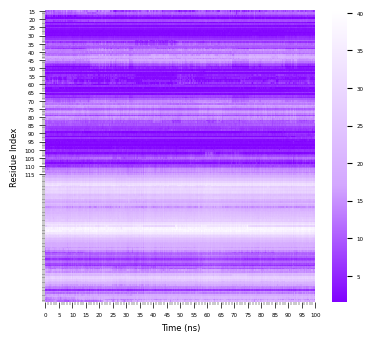

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

df = pd.DataFrame(heatDat)

# 创建自定义颜色映射
# 5以下颜色越小越深，大于等于5的白色
cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_cmap",
    [(0, "#8000FF"), (0.4, "#D3A7FF"), (1, "#ffffff")],
    N=512
)
#norm = mcolors.Normalize(vmin=0, vmax=5)
#cbar_kws={'ticks': []}

# 绘制热图
fig, ax = plt.subplots(figsize=(4, 3.5) )  # 设置图形大小
sns.heatmap(df, annot=False, cmap=cmap)#, norm=norm, fmt=".1f", cbar_kws=cbar_kws)  # 设置颜色条的标签
plt.yticks([x+0.5 for x in range(0, 101, 5)], range(15, 116, 5))
plt.xticks([x for x in range(0,1001,50)],[ x for x in range(0,101,5)],rotation=0)
ax.tick_params(axis="y",reset=True, which="both", direction="out", width=0.5, length=4,labelsize=4,right=False)
ax.tick_params(axis="y", which="minor",reset=True, direction="out", width=0.3, length=2,zorder=1,right=False)
ax.tick_params(axis="x", which="major", direction="out", width=0.5, length=4, right=False,labelsize=4)
ax.tick_params(axis="x", which="minor", direction="out", width=0.3, length=2, right=False)
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
#for i in range(0, 100, 1):
#    ax.axhline(i, color='grey',linewidth=0.1)
    #ax2.axvline(i, color='black',linewidth=0.2)

#plt.text(1115, 17,'d > 5Å', fontsize=4, rotation=-90)
#plt.text(1115, 46,'5Å ≥ d > 4Å', fontsize=4, rotation=-90)
#plt.text(1115, 71,'4Å ≥ d > 3Å', fontsize=4, rotation=-90)
#plt.text(1115, 92,'3Å ≥ d', fontsize=4, rotation=-90)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=4)  # 设置颜色条刻度的字体大小

plt.tight_layout(pad=1.5)
plt.ylabel("Residue Index", fontsize=6)
plt.xlabel("Time (ns)", fontsize=6)
plt.savefig("HeatMap.png", dpi=600)
plt.savefig("HeatMap.svg", dpi=600)
plt.show()


In [4]:
heatDat.iloc[0:101,:]

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
15,9.999,9.109,6.914,10.254,9.105,9.461,8.324,10.956,10.196,11.146,...,8.677,9.096,5.083,4.636,4.579,5.834,6.717,5.643,7.252,8.434
16,12.464,9.740,10.075,9.643,10.247,10.114,11.576,12.294,12.428,12.796,...,10.951,10.985,11.546,12.103,11.903,11.507,11.633,11.210,12.031,12.437
17,9.526,7.973,8.751,8.253,9.028,8.583,9.625,9.452,9.748,9.598,...,9.534,9.139,9.285,9.746,9.678,9.423,9.579,9.448,9.664,9.903
18,4.496,1.733,1.674,1.630,2.618,1.798,4.075,4.753,4.819,3.568,...,5.881,5.662,5.561,6.003,5.964,5.553,6.018,5.887,6.066,6.307
19,1.940,1.844,1.976,1.797,1.694,1.685,2.086,1.915,2.196,1.967,...,1.709,1.904,1.822,1.904,2.007,1.794,1.939,1.982,1.731,1.767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,8.645,8.892,9.265,9.239,9.634,9.209,8.614,9.117,9.803,9.279,...,10.383,11.049,10.496,10.998,10.880,11.321,9.778,10.711,10.418,10.489
112,11.153,12.332,11.514,12.998,12.416,11.689,8.839,9.799,12.684,11.905,...,14.157,14.647,14.141,14.968,14.881,14.446,13.563,14.485,13.989,14.469
113,13.715,13.466,13.870,13.453,13.936,13.666,13.083,13.817,13.973,13.552,...,14.717,14.626,14.935,15.580,15.455,16.065,13.985,15.085,14.790,14.618
114,13.350,13.397,13.936,13.104,13.328,12.814,13.077,13.445,13.501,13.034,...,14.304,13.436,13.795,14.358,14.158,15.130,13.027,14.557,13.871,14.383


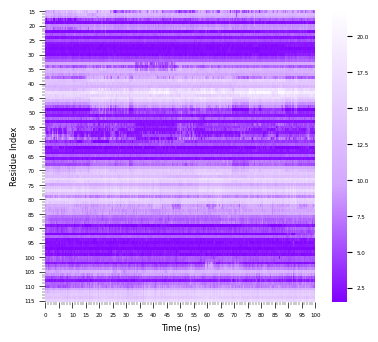

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

df = pd.DataFrame(heatDat.iloc[0:101,:])

# 创建自定义颜色映射
# 5以下颜色越小越深，大于等于5的白色
cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_cmap",
    [(0, "#8000FF"), (0.4, "#D3A7FF"), (1, "#ffffff")],
    N=512
)
#norm = mcolors.Normalize(vmin=0, vmax=5)
#cbar_kws={'ticks': []}

# 绘制热图
fig, ax = plt.subplots(figsize=(4, 3.5) )  # 设置图形大小
sns.heatmap(df, annot=False, cmap=cmap)#, norm=norm, fmt=".1f", cbar_kws=cbar_kws)  # 设置颜色条的标签
plt.yticks([x+0.5 for x in range(0, 101, 5)], range(15, 116, 5))
plt.xticks([x for x in range(0,1001,50)],[ x for x in range(0,101,5)],rotation=0)
ax.tick_params(axis="y",reset=True, which="both", direction="out", width=0.5, length=4,labelsize=4,right=False)
ax.tick_params(axis="y", which="minor",reset=True, direction="out", width=0.3, length=2,zorder=1,right=False)
ax.tick_params(axis="x", which="major", direction="out", width=0.5, length=4, right=False,labelsize=4)
ax.tick_params(axis="x", which="minor", direction="out", width=0.3, length=2, right=False)
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
#for i in range(0, 100, 1):
#    ax.axhline(i, color='grey',linewidth=0.1)
    #ax2.axvline(i, color='black',linewidth=0.2)

#plt.text(1115, 17,'d > 5Å', fontsize=4, rotation=-90)
#plt.text(1115, 46,'5Å ≥ d > 4Å', fontsize=4, rotation=-90)
#plt.text(1115, 71,'4Å ≥ d > 3Å', fontsize=4, rotation=-90)
#plt.text(1115, 92,'3Å ≥ d', fontsize=4, rotation=-90)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=4)  # 设置颜色条刻度的字体大小

plt.tight_layout(pad=1.5)
plt.ylabel("Residue Index", fontsize=6)
plt.xlabel("Time (ns)", fontsize=6)
plt.savefig("HeatMap.png", dpi=600)
plt.savefig("HeatMap.svg", dpi=600)
plt.show()
